In [1]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from dtbase.models.hodmd.run_pipeline import fetch_data
import matplotlib.pyplot as plt
from pydmd import HODMD
from pydmd.plotter import plot_eigs
from pydmd import ModesTuner

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def plot_data(xtrain_label, xtrain, xtest_label, xtest, plot_label):
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(xtrain_label, xtrain, label=[label + '_train' for label in plot_label])
    ax.plot(xtest_label, xtest, label=[label + '_test' for label in plot_label])
    ax.legend(loc='best')
    fig.show()

In [3]:
data = fetch_data()
print(data.keys())

INFO:dtbase.models.utils.dataprocessor.clean_data:Cleaning sensor data...


Training data from 2023-04-07 15:04:02.438643 to 2023-06-06 15:04:02.438643


INFO:dtbase.models.utils.dataprocessor.clean_data:Done cleaning sensor data.
INFO:dtbase.models.utils.dataprocessor.clean_data:Cleaning sensor data...
INFO:dtbase.models.utils.dataprocessor.clean_data:Done cleaning sensor data.
INFO:dtbase.models.utils.dataprocessor.prepare_data:Preparing the data to feed to the model...
INFO:dtbase.models.utils.dataprocessor.prepare_data:Done preparing the data. Ready to feed to the model.


dict_keys(['TRH1'])


In [4]:
data['TRH1']

,Temperature,Humidity
timestamp,,
2023-04-07 16:00:00+00:00,22.831055,63.218329
2023-04-07 17:00:00+00:00,23.288214,66.103339
2023-04-07 18:00:00+00:00,23.171134,65.461386
2023-04-07 19:00:00+00:00,23.514872,66.647733
2023-04-07 20:00:00+00:00,23.290169,66.685863
...,...,...
2023-06-06 00:00:00+00:00,22.205191,62.520740
2023-06-06 01:00:00+00:00,22.079161,59.444203
2023-06-06 02:00:00+00:00,20.331455,54.885856


In [5]:
legends = data['TRH1'].columns.tolist()
xdata_label = data['TRH1'].index.values
xdata = data['TRH1'].values
print(xdata_label.shape)
print(xdata.shape) # num_samples x num_sensor_measures
num_train_samples = int(0.8 * len(xdata))

xtrain_label = xdata_label[ : num_train_samples]
xtrain = xdata[ : num_train_samples, : ]
xtest_label = xdata_label[num_train_samples : ]
xtest = xdata[num_train_samples : , : ]

(1429,)
(1429, 2)


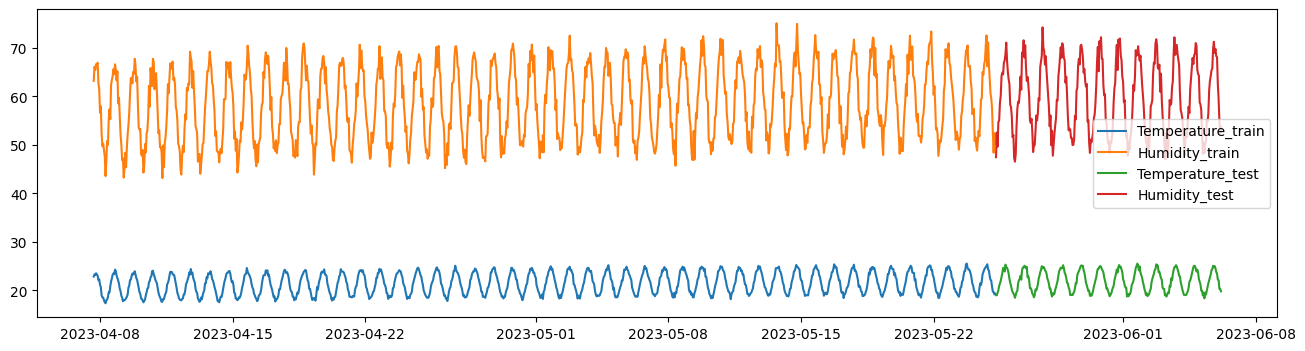

In [6]:
plot_data(xtrain_label, xtrain, xtest_label, xtest, legends)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
scaler = scaler.fit(xtrain)
xtrain_normalized = scaler.transform(xtrain)
xtest_normalized = scaler.transform(xtest)

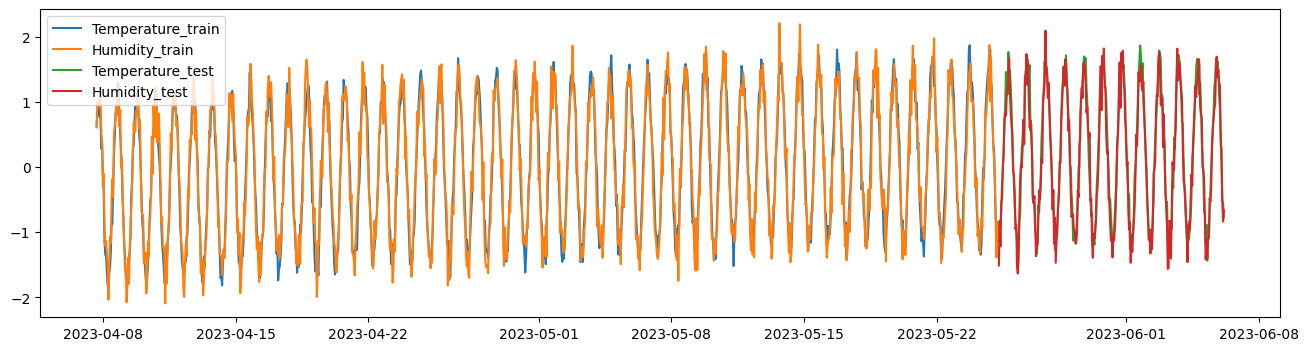

In [8]:
plot_data(xtrain_label, xtrain_normalized, xtest_label, xtest_normalized, legends)

In [9]:
snapshots = xtrain_normalized.T
print(snapshots.shape)

(2, 1143)


INFO:root:Snapshots: (2, 1143), snapshot shape: (2,)
INFO:root:Snapshots: (1, 1143), snapshot shape: (1,)
INFO:root:Snapshots: (250, 894), snapshot shape: (250,)
INFO:root:Snapshots: (250, 894), snapshot shape: (250,)


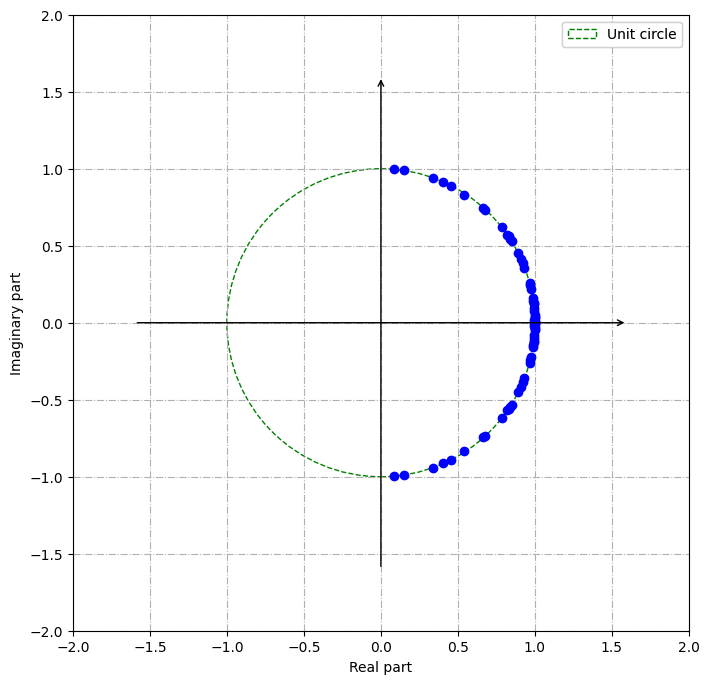

In [10]:
hodmd = HODMD(svd_rank = 0.99, svd_rank_extra = 0.9, exact = True, opt = True, d = 250, forward_backward = True, sorted_eigs = 'real').fit(snapshots)
plot_eigs(hodmd, show_axes=True, show_unit_circle=True)
hodmd.dmd_time['tend'] = len(xdata) - 1


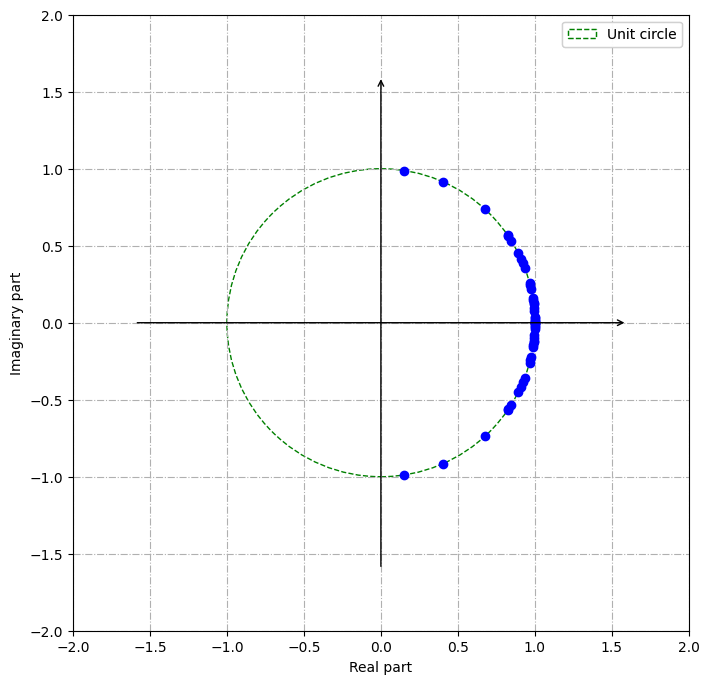

In [11]:
'''
=========================================================
DMD Mode truncation
=========================================================
'''

mtuner = ModesTuner(hodmd)
mtuner.select('integral_contribution', n=50)
#mtuner.select('stable_modes',max_distance_from_unity=1.e-3)
mtuner.stabilize(inner_radius=0.5, outer_radius=1.5)
tunedDMD= mtuner._dmds[0]
hodmd = tunedDMD

plot_eigs(hodmd, show_axes=True, show_unit_circle=True)

In [12]:
xreconstructed = hodmd.reconstructed_data.real
print(xreconstructed.shape)

(2, 1429)


In [13]:
print(xdata.shape)
print(xtrain_normalized.shape)

(1429, 2)
(1143, 2)


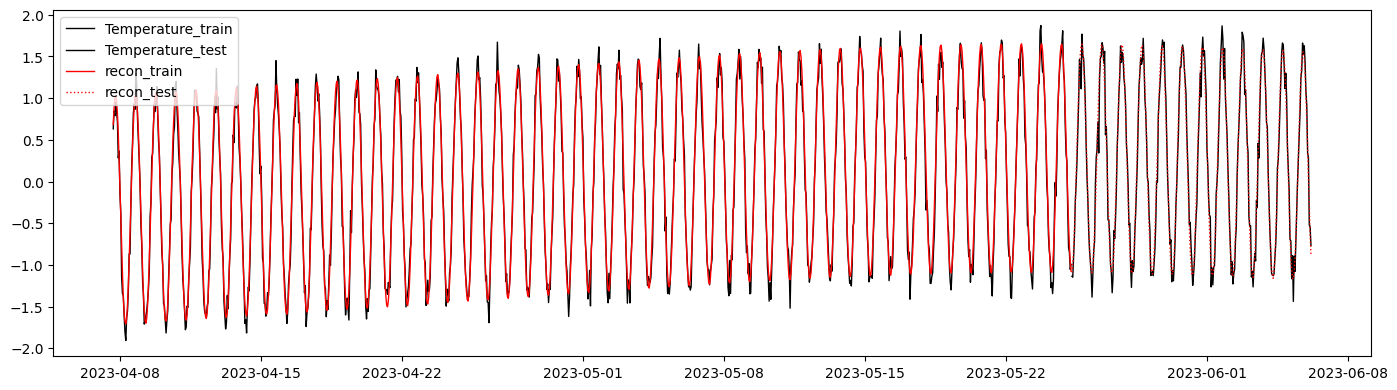

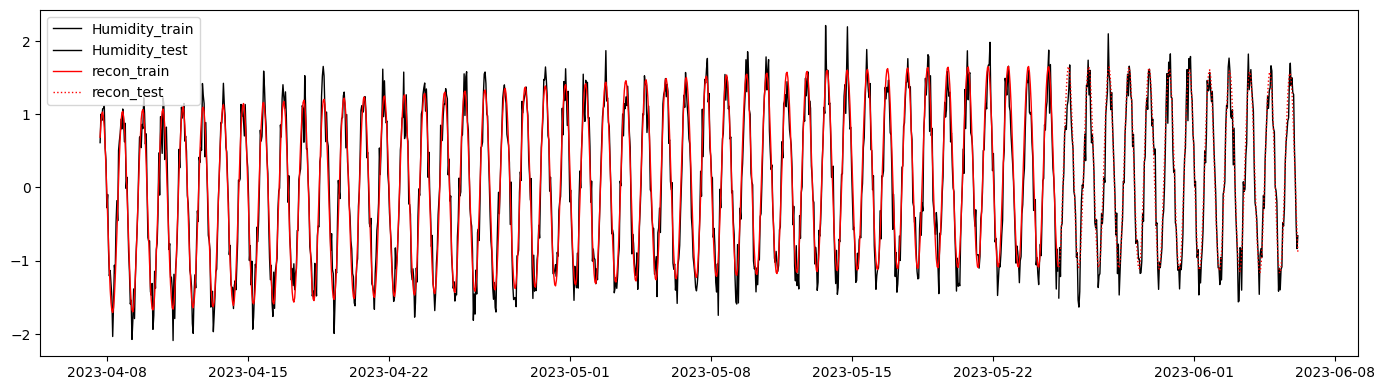

In [14]:
for idx, legend in enumerate(legends):
    fig, ax = plt.subplots(figsize=(17, 4.5))
    ax.plot(xtrain_label, xtrain_normalized[ : , idx], label=legend + '_train', c='k', linewidth = 1)
    ax.plot(xtest_label, xtest_normalized[ : , idx], label=legend + '_test', c='k', linewidth = 1)
    ax.plot(xtrain_label, xreconstructed[idx, : num_train_samples].T, label='recon_train', c='r', linewidth = 1)
    ax.plot(xtest_label, xreconstructed[idx, num_train_samples : ].T, ':', label='recon_test', c='r', linewidth = 1)
    ax.legend(loc='best')
    fig.show()